In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np

import pathlib
import shutil
import tempfile

import tensorflow as tf

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Training

Command used:

```
CUDA_VISIBLE_DEVICES=0 python src/models/train_model.py --epochs 100 --batch_size 64 --model_dir models --train data/processed/Tomato
```

In [5]:
from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
from src.data import io
from src.models.train_model import train, load_dataset

In [17]:
species = "Potato"
data_dir = pathlib.Path("../data/processed")
train_dir = data_dir.joinpath(species)
model_dir = pathlib.Path("../models")
metadata_file_path = train_dir.joinpath("metadata.json")

print(f"species: {species} - train_dir: {str(train_dir)} - metadata_file_path: {str(metadata_file_path)}")

species: Potato - train_dir: ../data/processed/Potato - metadata_file_path: ../data/processed/Potato/metadata.json


In [20]:
metadata = io.read_metadata(str(metadata_file_path))
model_id = metadata["id"]
print(f"model_id: {model_id}")

model_id: 5e3253d8-98c0-413f-ae94-bbd578500e78


In [21]:
batch_size = 32
epochs = 20
monitor = "val_loss"

In [22]:
classifier, history, _ = train(str(train_dir), str(model_dir), batch_size, epochs, monitor)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0

In [35]:
help(tfdocs.plots.HistoryPlotter)

Help on class HistoryPlotter in module tensorflow_docs.plots:

class HistoryPlotter(builtins.object)
 |  HistoryPlotter(metric=None, smoothing_std=None)
 |  
 |  A class for plotting named set of keras-histories.
 |  
 |  The class maintains colors for each key from plot to plot.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, metric=None, smoothing_std=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  plot(self, histories, metric=None, smoothing_std=None)
 |      Plots a {name: history} dictionary of keras histories.
 |      
 |      Colors are assigned to the name-key, and maintained from call to call.
 |      Training metrics are shown as a solid line, validation metrics dashed.
 |      
 |      Args:
 |        histories: {name: history} dictionary of keras histories.
 |        metric: which metric to plot from all the histories.
 |        smoothing_std: the standard-deviaation of the smoothing kernel applied
 |          before plotting. Th

In [31]:
np.array(history.history["loss"]).shape

(11,)

In [32]:
np.array(history.history["val_loss"]).shape

(11,)

In [36]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)

In [37]:
histories = {species: history}

In [50]:
from tensorflow.keras.callbacks import History

In [38]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [48]:
# https://chrisalbon.com/deep_learning/keras/visualize_loss_history/

def plot_learning_curve(history, metric):
    # Get training and test loss histories
    training_loss = np.array(history.history[metric])
    validation_loss = np.array(history.history[f"val_{metric}"])

    # Visualize loss history
    plt.plot(history.epoch, training_loss, 'r--')
    plt.plot(history.epoch, validation_loss, 'b-')
    plt.legend([f"Training {metric}", f"Validation {metric}"])
    plt.xlabel("epoch")
    plt.ylabel(metric)
    plt.show();

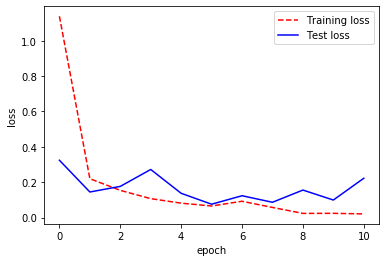

In [46]:
plot_learning_curve(history, "loss")

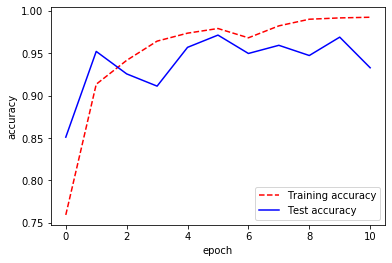

In [47]:
plot_learning_curve(history, "accuracy")

In [93]:
import pandas as pd

def create_metrics_for_dataset_type(history, dataset_type):
    loss_key = "loss"
    accuracy_key = "accuracy"
    
    if dataset_type == "validation":
        loss_key = "val_loss"
        accuracy_key = "val_accuracy"
    
    data = {
        "loss": history.history[loss_key],
        "accuracy": history.history[accuracy_key]
    }
    
    df = pd.DataFrame(data)
    df["epoch"] = df.index
    df["name"] = dataset_type
    
    return df


def create_metrics_dataframe(history):
    training_df = create_metrics_for_dataset_type(history, "train")
    validation_df = create_metrics_for_dataset_type(history, "validation")
    df = pd.concat([training_df, validation_df])
    df = df.reset_index()
    return df

In [94]:
metrics_df = create_metrics_dataframe(history)

In [95]:
metrics_df

,index,loss,accuracy,epoch,name
0,0,1.138377,0.759375,0,train
1,1,0.219636,0.913281,1,train
2,2,0.153681,0.941406,2,train
3,3,0.106946,0.964063,3,train
4,4,0.081243,0.973437,4,train
5,5,0.065310,0.978906,5,train
6,6,0.092052,0.967969,6,train
7,7,0.057122,0.982031,7,train
8,8,0.023421,0.989844,8,train
9,9,0.023834,0.991406,9,train


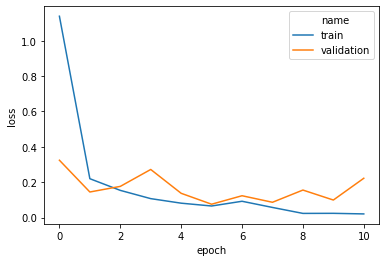

In [96]:
sns.lineplot(x="epoch", y="loss", hue="name", data=metrics_df, legend="full")

In [102]:
from src.visualization import visualize

In [104]:
metrics_df = visualize.create_metrics_dataframe(history.history)

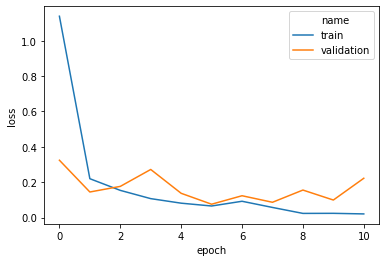

In [105]:
visualize.learning_curves("loss", metrics_df)

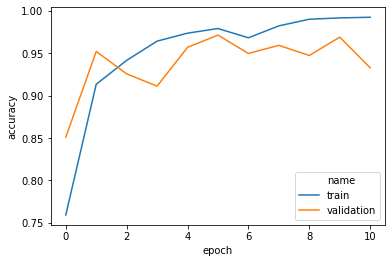

In [106]:
visualize.learning_curves("accuracy", metrics_df)

# Evaluation - Top Model

- **MODEL_ID** `9d01c36a-5654-4858-8343-e9b923b9bfc5`
- **EPOCH** `7`

On training and cross-validation datasets:

```
loss: 0.1227 - accuracy: 0.9583 - val_loss: 0.2684 - val_accuracy: 0.9219
```

On test dataset:

```
loss: 0.2630712818354368 - accuracy: 0.92578125 
```

In [22]:
for model_path in model_dir.glob("*.h5"):
    model_file_path = str(model_path)
    print(model_path.parent.name, model_path.name)
    model = tf.keras.models.load_model(model_file_path)
    loss, acc = evaluate(model, test_dataset, batch_size, metadata["file_counts"]["test"])
    print("loss:", loss, "-", "accuracy:", acc, "\n")

9d01c36a-5654-4858-8343-e9b923b9bfc5 3.h5
loss: 0.33715570425348623 - accuracy: 0.8844866 

9d01c36a-5654-4858-8343-e9b923b9bfc5 7.h5
loss: 0.2630712818354368 - accuracy: 0.92578125 

9d01c36a-5654-4858-8343-e9b923b9bfc5 final.h5
loss: 0.361284109630755 - accuracy: 0.91657364 

9d01c36a-5654-4858-8343-e9b923b9bfc5 2.h5
loss: 0.43175008893013 - accuracy: 0.8523995 

9d01c36a-5654-4858-8343-e9b923b9bfc5 1.h5
loss: 0.5357408262789249 - accuracy: 0.82561386 

9d01c36a-5654-4858-8343-e9b923b9bfc5 6.h5
loss: 0.3111253138631582 - accuracy: 0.906808 

